In [1]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.layers import CuDNNLSTM
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re


C:\Users\khfad\Anaconda33\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
path = "C:/Users/khfad/Desktop/ECE Final Project/data/aclimdb/"
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
#testFiles = [x for x in os.listdir(path+"test/") if x.endswith(".txt")]

In [38]:
positiveReviews, negativeReviews, testReviews = [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
#for tfile in testFiles:
#    with open(path+"test/"+tfile, encoding="latin1") as f:
#        testReviews.append(f.read())

In [39]:
reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    #pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)
reviews.head()

,review,label,file
21492,"I have copy of this on VHS, I think they (The television networks) should play this every year for the next twenty years. So that we don't forget what was and that we remember not to do the same mistakes again. Like putting some people in the director's chair, where they don't belong. This movie Rappin' is like a vaudevillian musical, for those who can't sing, or act. This movie is as much fun as trying to teach the 'blind' to drive a city bus.<br /><br />John Hood, (Peebles) has just got out of prison and he's headed back to the old neighborhood. In serving time for an all-to-nice crime of necessity, of course. John heads back onto the old street and is greeted by kids dogs old ladies and his peer homeys as they dance and sing all along the way.<br /><br />I would recommend this if I was sentimental, or if in truth someone was smoking medicinal pot prescribed by a doctor for glaucoma. Either way this is a poorly directed, scripted, acted and even produced (I never thought I'd sat that) satire of ghetto life with the 'Hood'. Although, I think the redeeming part of the story, through the wannabe gang fight sequences and the dance numbers, his friends care about their neighbors and want to save the ghetto from being torn down and cleaned up. <br /><br />Forget Sonny spoon, Mario could have won an Oscar for that in comparison to this Rap. Oh well if you find yourself wanting to laugh yourself silly and three-quarters embarrassed, be sure to drink first. <br /><br />And please, watch responsibly. (No stars, better luck next time!)",0,6844_1.txt
9488,"After several extremely well ratings to the point of SUPERB, I was extremely pleased with the film. The film was dark, moving, the anger, the pain, the guilt and a very extremely convincing demon.<br /><br />I had initially expected to see many special effects, and like a lover's caress, it blew me away with the subtlety and the rightness of it. Brian, I am again blown away with your artistry with the telling of the story and your care of the special effects. You will go a long way, my friend. I will definitely be the president of your fan club.<br /><br />Eric Etebari, the best actor award, was the number one choice. You made Jr. Lopez look like a child compared to Kasadya. :) <br /><br />Overall, the acting, story line, the high quality filming and awesome effects, it was fantastic. I just wish it were longer. I am looking forward to The Dreamless with extremely high expectations.",1,7290_10.txt
16933,"I still don't know why I forced myself to sit through the whole thing. This ""film"" wasn't worth the Memorex DVD-R it was burned on; I thought I was watching the end result of a group of middle schoolers stealing their parents' camcorder. This is by far the worst movie ever made. I truly, from the bottom of my heart, want to sue Aaron Yamasato for the two hours he stole from my life.<br /><br />So apparently, it's supposed to be bad on purpose; However, if you should end up in Hell and are forced to watch this 90-minute coil of doo-doo, you'll see that Yamasato is really trying hard to make an awesome flick. The actors attempt dramatic kick-ass performances comparable to Crimson Tide but come closer to The Marine.<br /><br />The crap acting is just the tip of the iceberg. The camera angles are awful. The story is C-movie at best-- the plot isn't even good enough to be considered B-movie caliber. The dialogue attempts to be dynamic and witty, but is crap like everything else. Rumor has it that a hard copy of the screenplay actually attracts flies. Plus, the techno score is annoying... not because it's techno, but because it's NON-STOP. That's right, the music plays in the background THE WHOLE TIME, acting as a subliminal reminder of how bad this thing is. I don't care what the disclaimer claims, I don't buy it. BOTS was not made this bad on purpose, because it takes itself WAY too serious for what it was: a joke.<br /><br />This ""film"" was very low-budget. 

In [41]:
reviews.shape

(25000, 3)

In [42]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [43]:
reviews['clean_review']=clean_review(reviews['review'].values)
reviews.head()

,review,label,file,clean_review
21492,"I have copy of this on VHS, I think they (The television networks) should play this every year for the next twenty years. So that we don't forget what was and that we remember not to do the same mistakes again. Like putting some people in the director's chair, where they don't belong. This movie Rappin' is like a vaudevillian musical, for those who can't sing, or act. This movie is as much fun as trying to teach the 'blind' to drive a city bus.<br /><br />John Hood, (Peebles) has just got out of prison and he's headed back to the old neighborhood. In serving time for an all-to-nice crime of necessity, of course. John heads back onto the old street and is greeted by kids dogs old ladies and his peer homeys as they dance and sing all along the way.<br /><br />I would recommend this if I was sentimental, or if in truth someone was smoking medicinal pot prescribed by a doctor for glaucoma. Either way this is a poorly directed, scripted, acted and even produced (I never thought I'd sat that) satire of ghetto life with the 'Hood'. Although, I think the redeeming part of the story, through the wannabe gang fight sequences and the dance numbers, his friends care about their neighbors and want to save the ghetto from being torn down and cleaned up. <br /><br />Forget Sonny spoon, Mario could have won an Oscar for that in comparison to this Rap. Oh well if you find yourself wanting to laugh yourself silly and three-quarters embarrassed, be sure to drink first. <br /><br />And please, watch responsibly. (No stars, better luck next time!)",0,6844_1.txt,i have copy of this on vhs i think they the television network should play this every year for the next twenty year so that we don t forget what wa and that we remember not to do the same mistake again like putting some people in the director s chair where they don t belong this movie rappin is like a vaudevillian musical for those who can t sing or act this movie is a much fun a trying to teach the blind to drive a city bus br br john hood peebles ha just got out of prison and he s headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john head back onto the old street and is greeted by kid dog old lady and his peer homeys a they dance and sing all along the way br br i would recommend this if i wa sentimental or if in truth someone wa smoking medicinal pot prescribed by a doctor for glaucoma either way this is a poorly directed scripted acted and even produced i never thought i d sat that satire of ghetto life with the hood although i think the redeeming part of the story through the wannabe gang fight sequence and the dance number his friend care about their neighbor and want to save the ghetto from being torn down and cleaned up br br forget sonny spoon mario could have won an oscar for that in comparison to this rap oh well if you find yourself wanting to laugh yourself silly and three quarter embarrassed be sure to drink first br br and please watch responsibly no star better luck next time
9488,"After several extremely well ratings to the point of SUPERB, I was extremely pleased with the film. The film was dark, moving, the anger, the pain, the guilt and a very extremely convincing demon.<br /><br />I had initially expected to see many special effects, and like a lover's caress, it blew me away with the subtlety and the rightness of it. Brian, I am again blown away with your artistry with the telling of the story and your care of the special effects. You will go a long way, my friend. I will definitely be the president of your fan club.<br /><br />Eric Etebari, the best actor award, was the number one choice. You made Jr. Lopez look like a child compared to Kasadya. :) <br /><br />Overall, the acting, story line, the high quality filming and awesome effects, it was fantastic. I just wish it were longer. I am looking forward to The Dreamless with extremely high expectations.",1,7290_10.txt,after sever

In [47]:
all_sentences=reviews.clean_review.values
target=reviews.label.values
#y=to_categorical(target)
y=target

In [48]:
y.shape

(25000,)

In [49]:
X_train_text,X_val_text,y_train,y_val=train_test_split(all_sentences,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(20000,) (20000,)
(5000,) (5000,)


In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train_text)

X_train = vectorizer.transform(X_train_text)
X_test  = vectorizer.transform(X_val_text)
X_train

<20000x59891 sparse matrix of type '<class 'numpy.int64'>'
	with 2683826 stored elements in Compressed Sparse Row format>

In [51]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Testing acc')
    plt.title('Training and testing accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Testing loss')
    plt.title('Training and testing loss')
    plt.legend()

In [52]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

2514

In [53]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 3
num_classes=2

In [54]:
from keras.preprocessing.text import Tokenizer
train_text=all_sentences
tokenizer = Tokenizer(num_words=num_unique_word)
tokenizer.fit_on_texts(all_sentences)

X_train = tokenizer.texts_to_sequences(X_train_text)
X_test = tokenizer.texts_to_sequences(X_val_text)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_text[2])
print(X_train[2])

i still don t know why i forced myself to sit through the whole thing this film wasn t worth the memorex dvd r it wa burned on i thought i wa watching the end result of a group of middle schoolers stealing their parent camcorder this is by far the worst movie ever made i truly from the bottom of my heart want to sue aaron yamasato for the two hour he stole from my life br br so apparently it s supposed to be bad on purpose however if you should end up in hell and are forced to watch this minute coil of doo doo you ll see that yamasato is really trying hard to make an awesome flick the actor attempt dramatic kick as performance comparable to crimson tide but come closer to the marine br br the crap acting is just the tip of the iceberg the camera angle are awful the story is c movie at best the plot isn t even good enough to be considered b movie caliber the dialogue attempt to be dynamic and witty but is crap like everything else rumor ha it that a hard copy of the screenplay actually 

In [55]:
from keras.preprocessing.sequence import pad_sequences

maxlen = MAX_REVIEW_LEN

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[3824    6   34 ...    0    0    0]


In [63]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50
input_dim = X_train.shape[1]  # Number of features

model0 = Sequential()
model0.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model0.add(layers.Dense(1, activation='sigmoid'))
model0.add(layers.Dense(10, activation='relu'))
model0.add(layers.Dense(1, activation='sigmoid'))
model0.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2514, 50)          3281700   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 3,282,221
Trainable params: 3,282,221
Non-trainable params: 0
_________________________________________________________________


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 107s 5ms/step - loss: 0.5443 - acc: 0.7770 - val_loss: 0.3701 - val_acc: 0.8448
Epoch 2/10
20000/20000 [==============================] - 138s 7ms/step - loss: 0.2922 - acc: 0.8830 - val_loss: 0.3002 - val_acc: 0.8756
Epoch 3/10
20000/20000 [==============================] - 184s 9ms/step - loss: 0.1942 - acc: 0.9279 - val_loss: 0.2856 - val_acc: 0.8866
Epoch 4/10
20000/20000 [==============================] - 218s 11ms/step - loss: 0.1212 - acc: 0.9617 - val_loss: 0.2861 - val_acc: 0.8888
Epoch 5/10
20000/20000 [==============================] - 217s 11ms/step - loss: 0.0698 - acc: 0.9825 - val_loss: 0.3016 - val_acc: 0.8846
Epoch 6/10
20000/20000 [==============================] - 238s 12ms/step - loss: 0.0377 - acc: 0.9928 - val_loss: 0.3225 - val_acc: 0.8852
Epoch 7/10
20000/20000 [==============================] - 231s 12ms/step - loss: 0.0192 - acc: 0.9980 - val_loss: 0.3495

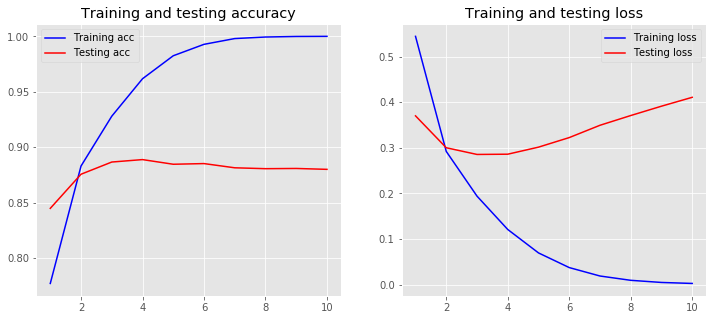

In [64]:
history = model0.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_val),
                    batch_size=50)
loss, accuracy = model0.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model0.evaluate(X_test, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)